In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from adjustText import adjust_text
plt.style.use(["science", "scatter", "no-latex"])

In [2]:
# regex patterns
PATTERNS = {
    "Status": re.compile(r"^\s*Status\s*:\s*(\S+)"),
    "Precondition time": re.compile(r"^\s*Precondition time\s*:\s*([\deE\+\-\.]+)"),
    "Iterations": re.compile(r"^\s*Iterations\s*:\s*(\d+)"),
    "Diagonal scaling used": re.compile(r"^\s*Diagonal scaling used\s*:\s*(yes|no)"),
    "Solve time": re.compile(r"^\s*Solve time\s*:\s*([\deE\+\-\.]+)"),
    "Primal objective": re.compile(r"^\s*Primal (?:obj|objective)\s*:\s*([\deE\+\-\.]+)"),
    "Dual objective": re.compile(r"^\s*Dual (?:obj|objective)\s*:\s*([\deE\+\-\.]+)")
}

## Parse Summary

In [3]:
def parse_slurm_file(path):
    """
    Parse a single slurm file
    """
    # init result
    results = {}
    current_instance = None

    # read lines
    with open(path, "r") as f:
        lines = f.readlines()

    # get info
    for line in lines:
        # detect a new instance
        m = re.search(r"^Instance:\s+(\S+)", line)
        if m:
            # init info for current instance
            current_instance = m.group(1)
            results[current_instance] = {
                "Status": None,
                "Precondition time": None,
                "Iterations": None,
                "Diagonal scaling used": None,
                "Solve time": None,
                "Primal obj": None,
                "Dual obj": None,
            }
            continue

        # skip if not an instance
        if current_instance is None:
            continue

        # match field
        for field, pat in PATTERNS.items():
            m = pat.search(line)
            # store info
            if m:
                value = m.group(1)
                results[current_instance][field] = m.group(1)

    return results

In [4]:
def load_benchmark(job_id):
    """
    Parse *.out files for a job id, merge their results, and return a pandas DataFrame
    """
    # files dir
    f1 = f".\\slurm\\slurm-c-vtx-benchmark-{job_id}_1.out"
    f2 = f".\\slurm\\slurm-c-vtx-benchmark-{job_id}_2.out"

    # existence check
    if not os.path.exists(f1) or not os.path.exists(f2):
        raise FileNotFoundError("Some slurm files not found.")

    # parse files
    r1 = parse_slurm_file(f1)
    r2 = parse_slurm_file(f2)

    # merrge the two results
    merged = merge_results(r1, r2)

    # convert to a DataFrame
    df = pd.DataFrame.from_dict(merged, orient="index")
    df.index.name = "Instance"
    return df

def merge_results(res1, res2):
    """
    Merge the parsed results from two files.
    """
    # init merged results
    merged = {}
    # union instance
    all_instances = set(res1.keys()) | set(res2.keys())

    for inst in all_instances:
        # instance existence check
        if inst not in res1 or inst not in res2:
            print(f"[WARNING] Instance {inst} missing in one file.")
            continue

        # get per-instance records
        r1, r2 = res1[inst], res2[inst]
        # init field for current instance
        merged[inst] = {}

        # numeric average
        merged[inst]["Precondition time"] = (float(r1["Precondition time"]) + float(r2["Precondition time"])) / 2
        merged[inst]["Solve time"] = (float(r1["Solve time"]) + float(r2["Solve time"])) / 2
        # check consistency for others
        for field in ["Status", "Iterations", "Primal objective", "Dual objective", "Diagonal scaling used"]:
            v1 = r1[field]
            v2 = r2[field]
            if v1 != v2:
                print(f"[WARNING] mismatch in {field} for instance {inst}: {v1} vs {v2}")
            if field == "Diagonal scaling used":
                merged[inst][field] = (str(v1).strip().lower() == "yes") if v1 is not None else False
            else:
                merged[inst][field] = v1
    return merged

In [5]:
def load_two_jobs(job1, job2):
    """
    Load and merge results from two benchmarks
    """
    # load per-job benchmark results
    df1 = load_benchmark(job1)
    df2 = load_benchmark(job2)

    # find duplicated instances
    overlap = df1.index.intersection(df2.index)
    for inst in overlap:
        print(f"[WARNING] duplicate instance '{inst}' found in both jobs "
              f"({job1} & {job2}); keeping job {job1}'s entry.")

    # drop duplicated instances from df2
    df2 = df2.drop(index=overlap)

    # concatenate along rows
    df_merged = pd.concat([df1, df2], axis=0)
    return df_merged

In [6]:
df_orig = load_two_jobs(8018377, 8018390)
df_diag = load_two_jobs(8312932, 8312940)

[WARNING] mismatch in Iterations for instance ns1687037: 254020200 vs 254332200
[WARNING] mismatch in Primal objective for instance ns1687037: 4.797011198 vs 4.799105569
[WARNING] mismatch in Dual objective for instance ns1687037: -246.7598423 vs -246.7074551
[WARNING] mismatch in Iterations for instance ds-big: 182200 vs 933200
[WARNING] mismatch in Primal objective for instance ds-big: 86.90576276 vs 86.83684649
[WARNING] mismatch in Dual objective for instance ds-big: 86.92298974 vs 86.81978274
[WARNING] mismatch in Iterations for instance neos-4535459-waipa: 7857000 vs 7883200
[WARNING] mismatch in Primal objective for instance neos-4535459-waipa: 3.060194435e+15 vs 3.057378886e+15
[WARNING] mismatch in Dual objective for instance neos-4535459-waipa: -4.356161665e+10 vs -4.367378039e+10
[WARNING] duplicate instance 'irish-electricity' found in both jobs (8018377 & 8018390); keeping job 8018377's entry.
[WARNING] duplicate instance 'savsched1' found in both jobs (8018377 & 8018390);

## Check Consistency

In [7]:
def check_obj_consistency(df_orig, df_diag, tol=1e-6):
    """
    Check the consistency of key fields.
    """
    # get instances
    common = df_orig.index.intersection(df_diag.index)

    # for each instance
    mismatch_count = 0
    for inst in common:
        rO = df_orig.loc[inst]
        rD = df_diag.loc[inst]

        # comparison with tolerance
        for field in ["Primal objective", "Dual objective"]:
            fO = float(rO[field])
            fD = float(rD[field])
            if abs(fO - fD) > tol:
                print(f"[WARNING] mismatch in {field} for instance {inst}:")
                # print a comparison table
                display_df = pd.DataFrame([rO, rD], index=["Original", "Diagnal"])[["Status", "Iterations", "Primal objective", "Dual objective"]]
                print(display_df.to_string())
                print("-" * 60)
                mismatch_count += 1
                break

    print(f"Total mismatches: {mismatch_count} / {len(common)} instances")

In [8]:
check_obj_consistency(df_orig, df_diag)

[WARNING] mismatch in Primal objective for instance irish-electricity:
           Status Iterations Primal objective Dual objective
Original  OPTIMAL     360200      2454404.014    2454418.333
Diagnal   OPTIMAL    1105600      2454387.271    2454402.821
------------------------------------------------------------
[WARNING] mismatch in Primal objective for instance square41:
           Status Iterations Primal objective Dual objective
Original  OPTIMAL     194600      8.850301505    8.848519102
Diagnal   OPTIMAL     222600      8.840734844    8.838969137
------------------------------------------------------------
[WARNING] mismatch in Primal objective for instance cont11:
           Status Iterations Primal objective Dual objective
Original  OPTIMAL     799200      61.08316857    61.07625882
Diagnal   OPTIMAL    9017000      63.73301728    63.72879021
------------------------------------------------------------
[WARNING] mismatch in Primal objective for instance fhnw-binschedule1:
    

In [9]:
def check_itr_consistency(df_orig, df_diag, rel_tol=0.01):
    """
    Check the consistency of key fields.
    """
    # get instances
    common = df_orig.index.intersection(df_diag.index)

    # for each instance
    mismatch_count = 0
    for inst in common:
        rO = df_orig.loc[inst]
        rD = df_diag.loc[inst]
        
        # comparison with tolerance
        iO = int(rO["Iterations"])
        iD = int(rD["Iterations"])
        rel_diff = abs(iO - iD) / max(iO, iD, 1.0)
        if rel_diff > rel_tol:
            print(f"[WARNING] more than 1% mismatch in Iterations for instance {inst}:")
            # print a comparison table
            display_df = pd.DataFrame([rO, rD], index=["Original", "Diagnal"])[["Status", "Iterations", "Primal objective", "Dual objective"]]
            print(display_df.to_string())
            print("-" * 60)
            mismatch_count += 1

    print(f"Total mismatches: {mismatch_count} / {len(common)} instances")

In [10]:
check_itr_consistency(df_orig, df_diag)

[WARNING] more than 1% mismatch in Iterations for instance irish-electricity:
           Status Iterations Primal objective Dual objective
Original  OPTIMAL     360200      2454404.014    2454418.333
Diagnal   OPTIMAL    1105600      2454387.271    2454402.821
------------------------------------------------------------
[WARNING] more than 1% mismatch in Iterations for instance square41:
           Status Iterations Primal objective Dual objective
Original  OPTIMAL     194600      8.850301505    8.848519102
Diagnal   OPTIMAL     222600      8.840734844    8.838969137
------------------------------------------------------------
[WARNING] more than 1% mismatch in Iterations for instance cont11:
           Status Iterations Primal objective Dual objective
Original  OPTIMAL     799200      61.08316857    61.07625882
Diagnal   OPTIMAL    9017000      63.73301728    63.72879021
------------------------------------------------------------
[WARNING] more than 1% mismatch in Iterations for inst

# Filter

In [11]:
def filter_diagonal_used(df_orig, df_diag):
    """
    Keep only instances where diagonal scaling was used.
    """
    mask = df_diag["Diagonal scaling used"] == True
    used_instances = df_diag.index[mask]

    print(f"[INFO] Diagonal scaling used on {len(used_instances)} instances:")
    for inst in used_instances:
        print(f"  - {inst}")

    df_orig = df_orig.loc[df_orig.index.intersection(used_instances)]
    df_diag = df_diag.loc[df_diag.index.intersection(used_instances)]

    return df_orig, df_diag

In [12]:
df_orig, df_diag = filter_diagonal_used(df_orig, df_diag)

[INFO] Diagonal scaling used on 99 instances:
  - irish-electricity
  - square41
  - cont11
  - fhnw-binschedule1
  - s100
  - rail02
  - s250r10
  - Primal2_1000
  - ns1687037
  - dlr2
  - Linf_520c
  - shs1023
  - cont1
  - s82
  - physiciansched3-3
  - bdry2
  - neos
  - ns1688926
  - dlr1
  - triptim7
  - supportcase6
  - supportcase7
  - neos-2987310-joes
  - 30n20b8
  - square31
  - shs1014
  - sp98ic
  - sing326
  - neos-4545615-waita
  - sing11
  - neos-4562542-watut
  - proteindesign122trx11p8
  - germanrr
  - proteindesign121hz512p9
  - triptim4
  - proteindesign121pgb11p9
  - ns1644855
  - hgms62
  - sing44
  - neos-873061
  - physiciansched6-1
  - neos-4533806-waima
  - square37
  - ds-big
  - triptim8
  - s55
  - mzzv11
  - piperout-d20
  - map14860-20
  - neos-3352863-ancoa
  - ci-s4
  - triptim1
  - neos-5013590-toitoi
  - ivu06
  - radiationm40-10-02
  - neos-4391920-timok
  - lr1dr04vc05v17a-t360
  - sct32
  - fhnw-binschedule0
  - map10
  - triptim2
  - sing5
  - ivu5

## Visualization

In [13]:
def plot_cpu_gpu_comparison(df_orig, df_diag, log=False):
    """
    CPU vs GPU time comparison.
    """
    # find common instances
    dfO = df_orig.copy()
    dfD = df_diag.copy()
    common = dfO.index.intersection(dfD.index)

    # extract times
    orig_iter = dfO["Iterations"].astype(float)
    diag_iter = dfD["Iterations"].astype(float)
    orig_sol = dfO["Solve time"].astype(float)
    diag_sol = dfD["Solve time"].astype(float)

    # color palette
    cmap = plt.get_cmap("tab10")
    color_pre = cmap(0)
    color_sol = cmap(1)
    edge_color = "black"

    # ============================================================
    # Figure 1 — Iterations
    # ============================================================
    plt.figure(figsize=(7, 6))
    # scatter points
    plt.scatter(orig_iter, diag_iter, s=45, alpha=0.8, color=color_pre, edgecolors=edge_color, linewidth=0.8)
    # y = x line
    max_pre = max(orig_iter.max(), diag_iter.max())
    plt.plot([0, max_pre], [0, max_pre], "k--", linewidth=1)
    # label
    plt.title("Iterations", fontsize=24, fontweight="bold")
    plt.xlabel("Orignal", fontsize=20)
    plt.ylabel("Diagnal Scaling", fontsize=20)
    # annotate instance
    #texts = []
    #for inst, x, y in zip(common, orig_iter, diag_iter):
    #    if dfD.loc[inst, "Diagonal scaling used"]:
    #        texts.append(plt.annotate(inst, (x, y), fontsize=10, color="black"))
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray"))
    # Log scale
    if log:
        plt.xscale("log")
        plt.yscale("log")
    # layout
    plt.tick_params(axis="both", which="major", labelsize=16)
    plt.tight_layout()
    plt.show()
    # ============================================================
    # Figure 2 — Solve Time
    # ============================================================
    plt.figure(figsize=(7, 6))
    # scatter points
    plt.scatter(orig_sol, diag_sol, s=45, alpha=0.8, color=color_sol, edgecolors=edge_color, linewidth=0.8)
    # y = x line
    max_sol = max(orig_sol.max(), diag_sol.max())
    plt.plot([0, max_sol], [0, max_sol], "k--", linewidth=1)
    # label
    plt.title("Solve Time", fontsize=24, fontweight="bold")
    plt.xlabel("Orignal", fontsize=20)
    plt.ylabel("Diagnal Scaling", fontsize=20)
    # annotate instance
    texts = []
    #for inst, x, y in zip(common, orig_iter, diag_iter):
    #    if dfD.loc[inst, "Diagonal scaling used"]:
    #        texts.append(plt.annotate(inst, (x, y), fontsize=10, color="black"))
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray"))
    # Log scale
    if log:
        plt.xscale("log")
        plt.yscale("log")
    # layout
    plt.tick_params(axis="both", which="major", labelsize=16)
    #plt.tight_layout()
    plt.show()

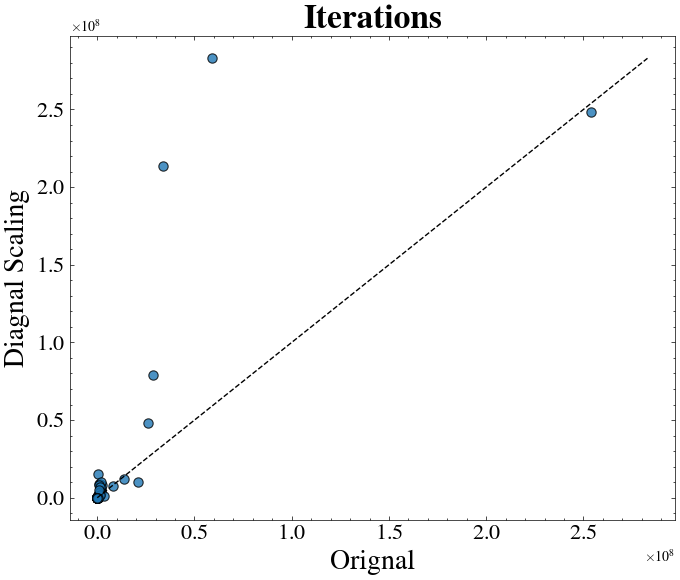

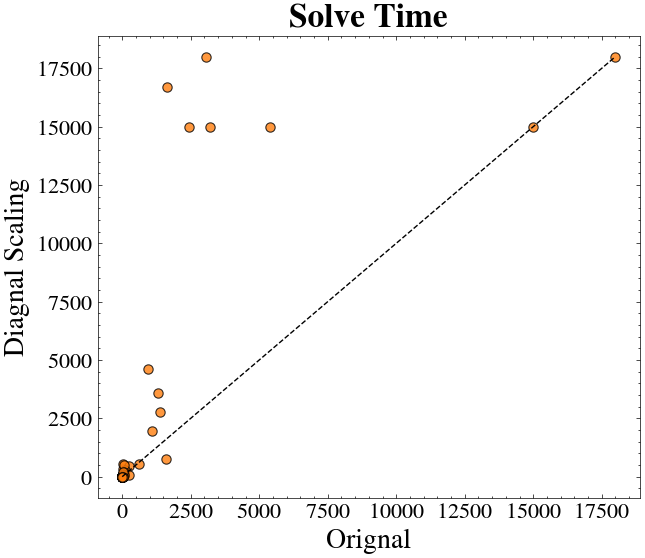

In [14]:
plot_cpu_gpu_comparison(df_orig, df_diag)

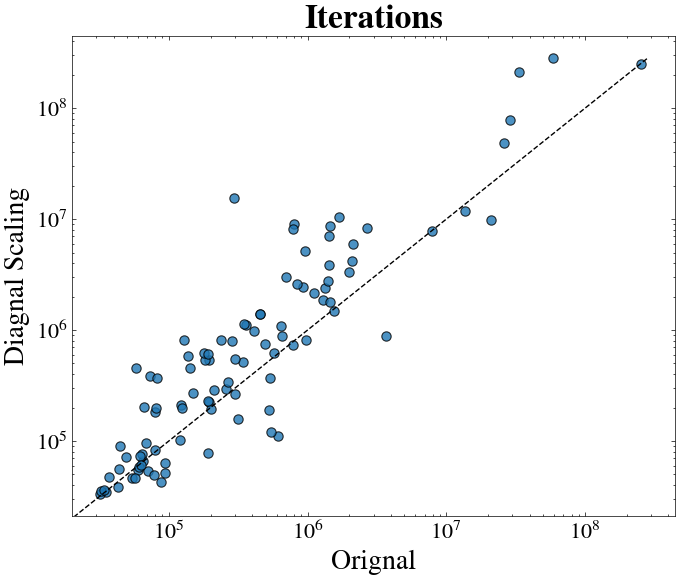

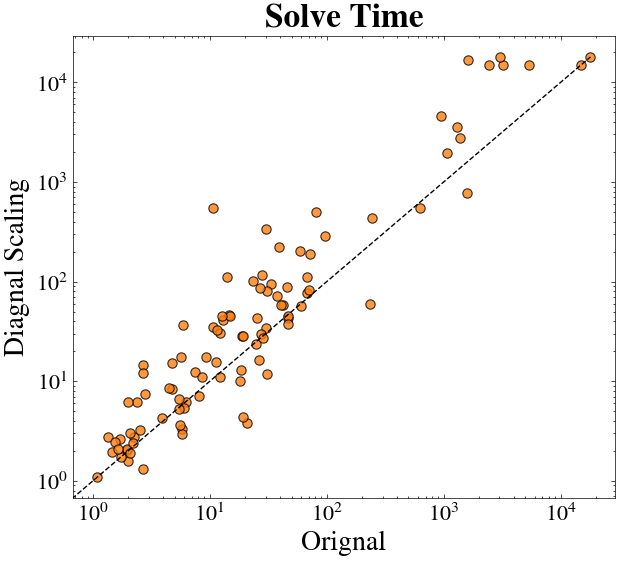

In [15]:
plot_cpu_gpu_comparison(df_orig, df_diag, log=True)